In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_csv("data.csv",parse_dates=["posted","scraped"])

# df = df.loc[df.test==False]

df["age"] = (df.scraped - df.posted).dt.total_seconds()//3600
df["weekday"] = df.posted.dt.day_name()
df["weekday_number"] = df.posted.dt.dayofweek
df["hour"] = df.posted.dt.hour
df["date"] = pd.to_datetime(df.posted.dt.date)
df["year"] = df.posted.dt.year
df["month"] = df.posted.dt.month
df["yrmnth"] = (df.year-2021)*12 + df.month
df["target"] = np.log(df.upvotes+1)

df["fhost"] = df.url.apply(lambda x: "imgur" if "imgur" in x else "reddit")
df["format"] = df.url.apply(lambda x: x.split(".")[-1])



sub = pd.read_csv("subscribers.csv",parse_dates=["timestamp"])

sub["date"] = sub.timestamp.dt.date

sub = sub.pivot(index="date",columns=["subreddit"],values="subscribers")

# Correcting any missing dates
daterange = pd.date_range(start=df.date.min(),end=df.date.max(),freq="D")
sub = sub.reindex(daterange)

# Filling in the new NULL values
sub.interpolate(method="linear",inplace=True)
sub.bfill(inplace=True)


# Adding the date back into the columns so we can melt the updated dataset
sub["date"] = pd.to_datetime(sub.index)
sub = pd.melt(sub,id_vars="date")


# Joining the two dataframes together
df = df.merge(sub.rename(columns={"value":"subscribers"}),how="left",on=["date","subreddit"])





stage1 = df.groupby(["date","subreddit","category","hour"],as_index=False).agg({"upvotes":"count"}).rename(columns={"upvotes":"competition_subreddit"})
stage2 = stage1.groupby(["date","hour","category"],as_index=False).agg({"competition_subreddit":"sum"}).rename(columns={"competition_subreddit":"competition_category"})
stage3 = stage2.groupby(["date","hour"],as_index=False).agg({"competition_category":"sum"}).rename(columns={"competition_category":"competition_total"})



df = df.merge(stage1,how="left",on=["date","hour","subreddit","category"]).merge(stage2,how="left",on=["date","hour","category"]).merge(stage3,how="left",on=["date","hour"])

df.head()



,fname,url,category,subreddit,title,description,upvotes,posted,scraped,niche,...,year,month,yrmnth,target,fhost,format,subscribers,competition_subreddit,competition_category,competition_total
0,cgptykrzcez71.jpg,https://i.redd.it/cgptykrzcez71.jpg,cats,catpictures,Caturday morning TV 😺,NaN,247.0,2021-11-13 11:22:11,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,5.513429,reddit,jpg,142344.0,1,5,17
1,EGjVMqx.jpg,https://i.imgur.com/EGjVMqx.jpg,cats,catpictures,Round loaf!,NaN,24.0,2021-11-13 02:23:31,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,3.218876,imgur,jpg,142344.0,1,2,4
2,y45936kis8z71.jpg,https://i.redd.it/y45936kis8z71.jpg,cats,catpictures,Taken over fall wreath,NaN,427.0,2021-11-12 16:38:49,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,6.059123,reddit,jpg,142344.0,2,7,21
3,irl2nzyro8z71.jpg,https://i.redd.it/irl2nzyro8z71.jpg,cats,catpictures,"My kitten, Topaz!",NaN,196.0,2021-11-12 16:17:45,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,5.283204,reddit,jpg,142344.0,2,7,21
4,vlsh4hijg8z71.jpg,https://i.redd.it/vlsh4hijg8z71.jpg,cats,catpictures,My Tom is not impressed having to wait for the...,NaN,620.0,2021-11-12 15:31:23,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,6.431331,reddit,jpg,142344.0,1,4,19


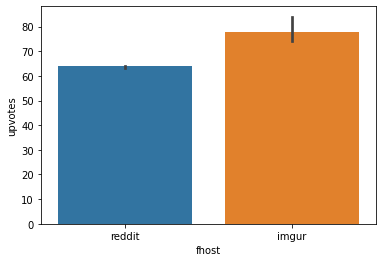

In [32]:
sns.barplot(data=df,x="fhost",y="upvotes",estimator=np.median);

<AxesSubplot:xlabel='hour', ylabel='upvotes'>

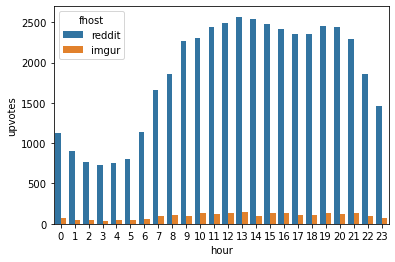

In [33]:
sns.barplot(data=df,x="hour",y="upvotes",estimator=len,hue="fhost")

<AxesSubplot:xlabel='hour', ylabel='upvotes'>

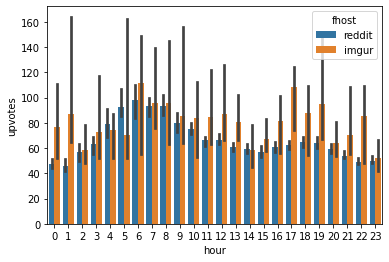

In [34]:
sns.barplot(data=df,x="hour",y="upvotes",estimator=np.median,hue="fhost")

In [18]:
df.url.apply(lambda x: x.split(".")[-1]).value_counts()

jpg     45828
png       733
jpeg       99
gif        70
Name: url, dtype: int64

In [19]:
df["test"] = df.url.apply(lambda x: x.split(".")[-1])

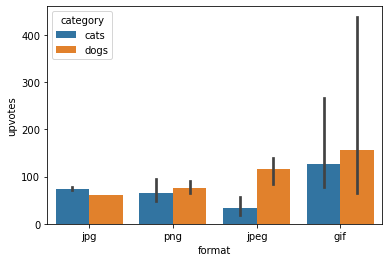

In [35]:
sns.barplot(data=df,x="format",y="upvotes",estimator=np.median,hue="category");

In [4]:
df["title_length"] = df.title.apply(lambda x: len(x.split(" ")))

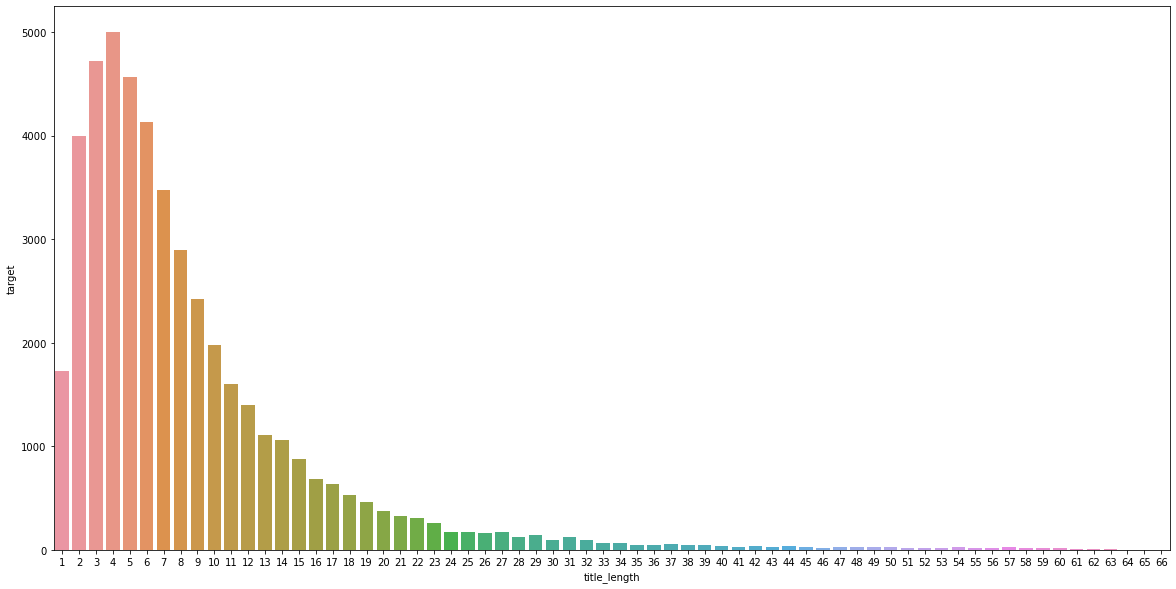

In [7]:
fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(data=df,x="title_length",y="target",estimator=len);

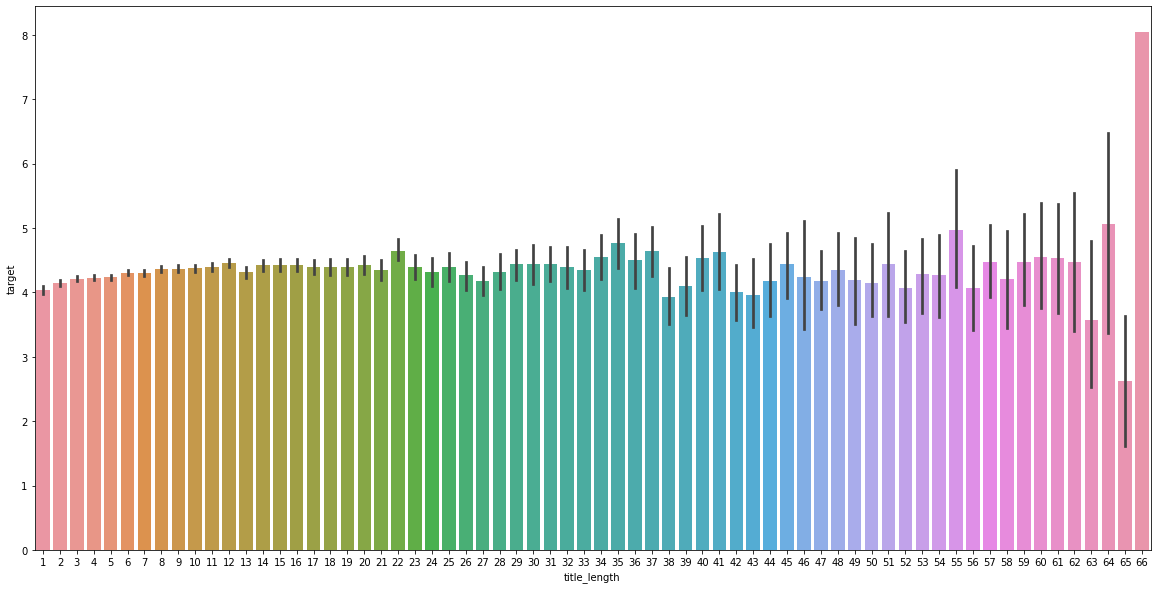

In [8]:
fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(data=df,x="title_length",y="target");

In [13]:
df.groupby(["title_length"],as_index=False).agg({"upvotes":"count"}).sort_values("title_length")

,title_length,upvotes
0,1,1724
1,2,3998
2,3,4716
3,4,4998
4,5,4564
...,...,...
61,62,9
62,63,7
63,64,3
64,65,2


In [17]:
df.loc[df.title_length==66,"title"].values[0]

'My poor girl broke her leg when i let her outside. I dont know how and she was in so much pain. I dont know what to do. My wife is taking her to the vet while i stay home with our daughter right now. I dont know how im going to pay for her vet bill. Im so distraught, She the sweet dog i know.'

In [21]:
df.loc[df.title_length==65,"title"].values

array(["I'm in constant fear for my nose and lips. I can just be on my phone and he just pounces on me and just starts barking so loudly in my face. Like sir no. I just keep petting him and saying 'I love my Taki' and that gets him sometimes. Like I swear if he was a big dog he would be feared by all.",
       'I gave a hitchhiker a ride in the back of my truck. Opie stared out the back at him the whole time then tried to break through the window. The man was literally about to jump out of my truck at 35mph thinking Opie would get him so I had to stop and let him back out. I really felt bad for the guy. 🦛😮'],
      dtype=object)

In [36]:
from sklearn.metrics import mean_squared_error as mse

In [37]:
df["benchmark"] = df.target.mean()

In [38]:
mse(df.target,df.benchmark,squared=False)

1.3308108920774133

In [42]:
df.columns

Index(['fname', 'url', 'category', 'subreddit', 'title', 'description',
       'upvotes', 'posted', 'scraped', 'niche', 'test', 'age', 'weekday',
       'weekday_number', 'hour', 'date', 'year', 'month', 'yrmnth', 'target',
       'fhost', 'format', 'subscribers', 'competition_subreddit',
       'competition_category', 'competition_total'],
      dtype='object')

### Metadata Model

In [14]:
df.columns

Index(['fname', 'url', 'category', 'subreddit', 'title', 'description',
       'upvotes', 'posted', 'scraped', 'niche', 'test', 'age', 'weekday',
       'weekday_number', 'hour', 'date', 'year', 'month', 'yrmnth', 'target',
       'fhost', 'format', 'subscribers', 'competition_subreddit',
       'competition_category', 'competition_total', 'subject'],
      dtype='object')

In [27]:
train = df[~df.test]
test = df[df.test]

In [30]:
train.target.describe()

count    4.673000e+04
mean    -5.711870e-14
std      1.000000e+00
min     -3.222527e+00
25%     -6.922950e-01
50%     -8.583557e-02
75%      6.365818e-01
max      4.352289e+00
Name: target, dtype: float64

In [28]:
test["target"] -= train.target.mean()
test["target"] /= train.target.std()
train["target"] -= train.target.mean()
train["target"] /= train.target.std()

C:\Users\alexi\AppData\Local\Temp/ipykernel_21956/203283660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target"] -= train.target.mean()
C:\Users\alexi\AppData\Local\Temp/ipykernel_21956/203283660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target"] /= train.target.std()
C:\Users\alexi\AppData\Local\Temp/ipykernel_21956/203283660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [19]:
train.head()

,fname,url,category,subreddit,title,description,upvotes,posted,scraped,niche,...,month,yrmnth,target,fhost,format,subscribers,competition_subreddit,competition_category,competition_total,subject
0,cgptykrzcez71.jpg,https://i.redd.it/cgptykrzcez71.jpg,cats,catpictures,Caturday morning TV 😺,NaN,247.0,2021-11-13 11:22:11,2021-11-21 09:28:28.376338,0.0,...,11,11,0.920338,reddit,jpg,142344.0,1,3,12,Other
1,EGjVMqx.jpg,https://i.imgur.com/EGjVMqx.jpg,cats,catpictures,Round loaf!,NaN,24.0,2021-11-13 02:23:31,2021-11-21 09:28:28.376338,0.0,...,11,11,-0.803820,imgur,jpg,142344.0,1,2,4,Other
2,y45936kis8z71.jpg,https://i.redd.it/y45936kis8z71.jpg,cats,catpictures,Taken over fall wreath,NaN,427.0,2021-11-12 16:38:49,2021-11-21 09:28:28.376338,0.0,...,11,11,1.330380,reddit,jpg,142344.0,2,6,18,Other
3,irl2nzyro8z71.jpg,https://i.redd.it/irl2nzyro8z71.jpg,cats,catpictures,"My kitten, Topaz!",NaN,196.0,2021-11-12 16:17:45,2021-11-21 09:28:28.376338,0.0,...,11,11,0.747344,reddit,jpg,142344.0,2,6,18,Other
4,vlsh4hijg8z71.jpg,https://i.redd.it/vlsh4hijg8z71.jpg,cats,catpictures,My Tom is not impressed having to wait for the...,NaN,620.0,2021-11-12 15:31:23,2021-11-21 09:28:28.376338,0.0,...,11,11,1.610063,reddit,jpg,142344.0,1,3,14,Other


In [31]:
num = ["niche","year","subscribers","hour","competition_subreddit","competition_category","competition_total","age"]
cat = ["category","subreddit","month","fhost","format","subject","weekday"]
target = ["target"]

In [24]:
subjects = {"holiday":["birthday","santa","xmas","christmas","holiday","valentine","halloween","easter","thanksgiving"]
           ,"death/injury":["broke her","broke his","hard time bending ","not feeling so good","not feeling well","the labs gone","splenectomy","post op","passed away","miss her","miss him","surgery","seizure","missing","hospital","hit by car","died"]
           ,"sleep":["cozy","chill","dreaming","lazy","bed time","bedtime","slumber","lazing","blanket","snooze","sleepy","snug ","sleep","cuddlin","tired","snoozin","loungin","snuggle","cuddle","chillin","sweepy","leisure","nappin","nap ","nap,"]
           ,"new":["new add","rescued","newest","just adopted"]
            ,"sun":["enjoying morning sun","soaking up the sun","enjoying the sun","sunshine","enjoying the shade","in the sun","sunbeam","sun beam"]
           ,"snow":["snow","winter","cold","-3"]
#            ,"cat":["tail wrap","toe bean"]
           ,"playful":["play","fetch","tug"]
#            ,"naughty":["naughty","bad girl","bad boy"]
#            ,"poses":["pose","photogenic","photoshoot"]
#            ,"walk":["walk","stroll","leash","hike"]
#             ,"good morning":["good morning","good evening","good night","Good murrrrning"]
#            ,"cute":["beautiful","cutie","cute","handsome"]
           }

In [25]:
def label(x):
    
    for subject,keywords in subjects.items():
        
        for kw in keywords:
            if kw in x.lower():
                return subject
            
    return "Other"

In [26]:
df["subject"] = df.title.apply(label)

In [33]:
!pip install catboost

In [34]:
from catboost import CatBoostRegressor

In [36]:
model = CatBoostRegressor()

In [37]:
model.fit(train[cat+num],train[target],cat_features=cat)

Learning rate set to 0.075158
0:	learn: 0.9928991	total: 169ms	remaining: 2m 49s
1:	learn: 0.9863420	total: 203ms	remaining: 1m 41s
2:	learn: 0.9810034	total: 238ms	remaining: 1m 19s
3:	learn: 0.9761558	total: 270ms	remaining: 1m 7s
4:	learn: 0.9722750	total: 299ms	remaining: 59.4s
5:	learn: 0.9688217	total: 328ms	remaining: 54.4s
6:	learn: 0.9655562	total: 357ms	remaining: 50.7s
7:	learn: 0.9623930	total: 393ms	remaining: 48.7s
8:	learn: 0.9596989	total: 443ms	remaining: 48.7s
9:	learn: 0.9572652	total: 476ms	remaining: 47.1s
10:	learn: 0.9548623	total: 509ms	remaining: 45.8s
11:	learn: 0.9531702	total: 541ms	remaining: 44.6s
12:	learn: 0.9513330	total: 579ms	remaining: 44s
13:	learn: 0.9496685	total: 623ms	remaining: 43.9s
14:	learn: 0.9483133	total: 660ms	remaining: 43.3s
15:	learn: 0.9467944	total: 706ms	remaining: 43.4s
16:	learn: 0.9455329	total: 739ms	remaining: 42.7s
17:	learn: 0.9443613	total: 798ms	remaining: 43.5s
18:	learn: 0.9434785	total: 859ms	remaining: 44.4s
19:	learn:

165:	learn: 0.9155099	total: 7.31s	remaining: 36.7s
166:	learn: 0.9154610	total: 7.35s	remaining: 36.6s
167:	learn: 0.9154126	total: 7.39s	remaining: 36.6s
168:	learn: 0.9153402	total: 7.44s	remaining: 36.6s
169:	learn: 0.9152850	total: 7.48s	remaining: 36.5s
170:	learn: 0.9152775	total: 7.53s	remaining: 36.5s
171:	learn: 0.9151242	total: 7.58s	remaining: 36.5s
172:	learn: 0.9150651	total: 7.62s	remaining: 36.4s
173:	learn: 0.9149689	total: 7.67s	remaining: 36.4s
174:	learn: 0.9148803	total: 7.72s	remaining: 36.4s
175:	learn: 0.9147725	total: 7.76s	remaining: 36.4s
176:	learn: 0.9146354	total: 7.82s	remaining: 36.4s
177:	learn: 0.9146298	total: 7.86s	remaining: 36.3s
178:	learn: 0.9145908	total: 7.89s	remaining: 36.2s
179:	learn: 0.9145426	total: 7.92s	remaining: 36.1s
180:	learn: 0.9144933	total: 7.99s	remaining: 36.1s
181:	learn: 0.9144278	total: 8.02s	remaining: 36s
182:	learn: 0.9142814	total: 8.05s	remaining: 36s
183:	learn: 0.9142565	total: 8.08s	remaining: 35.8s
184:	learn: 0.91

324:	learn: 0.9058873	total: 14.4s	remaining: 29.9s
325:	learn: 0.9058076	total: 14.4s	remaining: 29.8s
326:	learn: 0.9057623	total: 14.5s	remaining: 29.8s
327:	learn: 0.9057420	total: 14.5s	remaining: 29.7s
328:	learn: 0.9056309	total: 14.5s	remaining: 29.6s
329:	learn: 0.9055966	total: 14.6s	remaining: 29.6s
330:	learn: 0.9055568	total: 14.6s	remaining: 29.6s
331:	learn: 0.9055505	total: 14.7s	remaining: 29.5s
332:	learn: 0.9055252	total: 14.7s	remaining: 29.4s
333:	learn: 0.9054623	total: 14.8s	remaining: 29.4s
334:	learn: 0.9054381	total: 14.8s	remaining: 29.4s
335:	learn: 0.9054198	total: 14.8s	remaining: 29.3s
336:	learn: 0.9054004	total: 14.9s	remaining: 29.2s
337:	learn: 0.9053900	total: 14.9s	remaining: 29.3s
338:	learn: 0.9053427	total: 15s	remaining: 29.3s
339:	learn: 0.9053000	total: 15s	remaining: 29.2s
340:	learn: 0.9052136	total: 15.1s	remaining: 29.2s
341:	learn: 0.9051074	total: 15.2s	remaining: 29.2s
342:	learn: 0.9050393	total: 15.2s	remaining: 29.1s
343:	learn: 0.90

487:	learn: 0.8993895	total: 22.3s	remaining: 23.4s
488:	learn: 0.8992926	total: 22.3s	remaining: 23.3s
489:	learn: 0.8992792	total: 22.4s	remaining: 23.3s
490:	learn: 0.8992391	total: 22.4s	remaining: 23.3s
491:	learn: 0.8992121	total: 22.5s	remaining: 23.2s
492:	learn: 0.8991819	total: 22.5s	remaining: 23.2s
493:	learn: 0.8991569	total: 22.6s	remaining: 23.1s
494:	learn: 0.8991020	total: 22.6s	remaining: 23.1s
495:	learn: 0.8990839	total: 22.7s	remaining: 23s
496:	learn: 0.8990267	total: 22.7s	remaining: 23s
497:	learn: 0.8989803	total: 22.8s	remaining: 23s
498:	learn: 0.8989667	total: 22.8s	remaining: 22.9s
499:	learn: 0.8989281	total: 22.9s	remaining: 22.9s
500:	learn: 0.8988866	total: 22.9s	remaining: 22.8s
501:	learn: 0.8988818	total: 23s	remaining: 22.8s
502:	learn: 0.8988311	total: 23s	remaining: 22.7s
503:	learn: 0.8987889	total: 23.1s	remaining: 22.7s
504:	learn: 0.8987634	total: 23.1s	remaining: 22.6s
505:	learn: 0.8986857	total: 23.1s	remaining: 22.6s
506:	learn: 0.8986623	

647:	learn: 0.8940140	total: 29.5s	remaining: 16s
648:	learn: 0.8939926	total: 29.5s	remaining: 15.9s
649:	learn: 0.8939661	total: 29.5s	remaining: 15.9s
650:	learn: 0.8939338	total: 29.6s	remaining: 15.9s
651:	learn: 0.8939115	total: 29.6s	remaining: 15.8s
652:	learn: 0.8938689	total: 29.6s	remaining: 15.8s
653:	learn: 0.8938111	total: 29.7s	remaining: 15.7s
654:	learn: 0.8937917	total: 29.7s	remaining: 15.7s
655:	learn: 0.8937700	total: 29.8s	remaining: 15.6s
656:	learn: 0.8937306	total: 29.9s	remaining: 15.6s
657:	learn: 0.8936946	total: 29.9s	remaining: 15.5s
658:	learn: 0.8936795	total: 29.9s	remaining: 15.5s
659:	learn: 0.8936674	total: 30s	remaining: 15.4s
660:	learn: 0.8936631	total: 30s	remaining: 15.4s
661:	learn: 0.8936436	total: 30.1s	remaining: 15.4s
662:	learn: 0.8936182	total: 30.2s	remaining: 15.3s
663:	learn: 0.8935488	total: 30.2s	remaining: 15.3s
664:	learn: 0.8934985	total: 30.2s	remaining: 15.2s
665:	learn: 0.8934875	total: 30.3s	remaining: 15.2s
666:	learn: 0.8934

806:	learn: 0.8894561	total: 37s	remaining: 8.86s
807:	learn: 0.8894328	total: 37.1s	remaining: 8.81s
808:	learn: 0.8894173	total: 37.1s	remaining: 8.76s
809:	learn: 0.8893399	total: 37.2s	remaining: 8.72s
810:	learn: 0.8893341	total: 37.2s	remaining: 8.67s
811:	learn: 0.8892997	total: 37.3s	remaining: 8.62s
812:	learn: 0.8892368	total: 37.3s	remaining: 8.58s
813:	learn: 0.8891887	total: 37.3s	remaining: 8.53s
814:	learn: 0.8891757	total: 37.4s	remaining: 8.48s
815:	learn: 0.8891458	total: 37.4s	remaining: 8.43s
816:	learn: 0.8890916	total: 37.5s	remaining: 8.4s
817:	learn: 0.8890313	total: 37.5s	remaining: 8.35s
818:	learn: 0.8890007	total: 37.6s	remaining: 8.31s
819:	learn: 0.8889756	total: 37.7s	remaining: 8.27s
820:	learn: 0.8889734	total: 37.7s	remaining: 8.22s
821:	learn: 0.8889162	total: 37.8s	remaining: 8.18s
822:	learn: 0.8889030	total: 37.8s	remaining: 8.13s
823:	learn: 0.8888832	total: 37.9s	remaining: 8.09s
824:	learn: 0.8888592	total: 37.9s	remaining: 8.04s
825:	learn: 0.8

966:	learn: 0.8848595	total: 45.9s	remaining: 1.57s
967:	learn: 0.8848275	total: 46s	remaining: 1.52s
968:	learn: 0.8847721	total: 46s	remaining: 1.47s
969:	learn: 0.8847691	total: 46.1s	remaining: 1.43s
970:	learn: 0.8847318	total: 46.2s	remaining: 1.38s
971:	learn: 0.8847115	total: 46.2s	remaining: 1.33s
972:	learn: 0.8846805	total: 46.3s	remaining: 1.28s
973:	learn: 0.8846365	total: 46.3s	remaining: 1.24s
974:	learn: 0.8845865	total: 46.4s	remaining: 1.19s
975:	learn: 0.8845825	total: 46.4s	remaining: 1.14s
976:	learn: 0.8845522	total: 46.5s	remaining: 1.09s
977:	learn: 0.8845477	total: 46.5s	remaining: 1.05s
978:	learn: 0.8845300	total: 46.6s	remaining: 999ms
979:	learn: 0.8845217	total: 46.6s	remaining: 951ms
980:	learn: 0.8845114	total: 46.6s	remaining: 903ms
981:	learn: 0.8845053	total: 46.7s	remaining: 856ms
982:	learn: 0.8844848	total: 46.7s	remaining: 808ms
983:	learn: 0.8844502	total: 46.8s	remaining: 761ms
984:	learn: 0.8844127	total: 46.8s	remaining: 713ms
985:	learn: 0.88

In [38]:
pred = model.predict(test[cat+num])

In [40]:
from sklearn.metrics import mean_squared_error as mse

In [41]:
mse(pred,test.target,squared=False)

0.9190508525598248

In [45]:
test["pred"] = pred

C:\Users\alexi\AppData\Local\Temp/ipykernel_21956/1330184522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred"] = pred


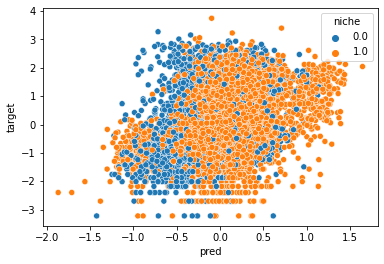

In [50]:
sns.scatterplot(data=test,x="pred",y="target",hue="niche");

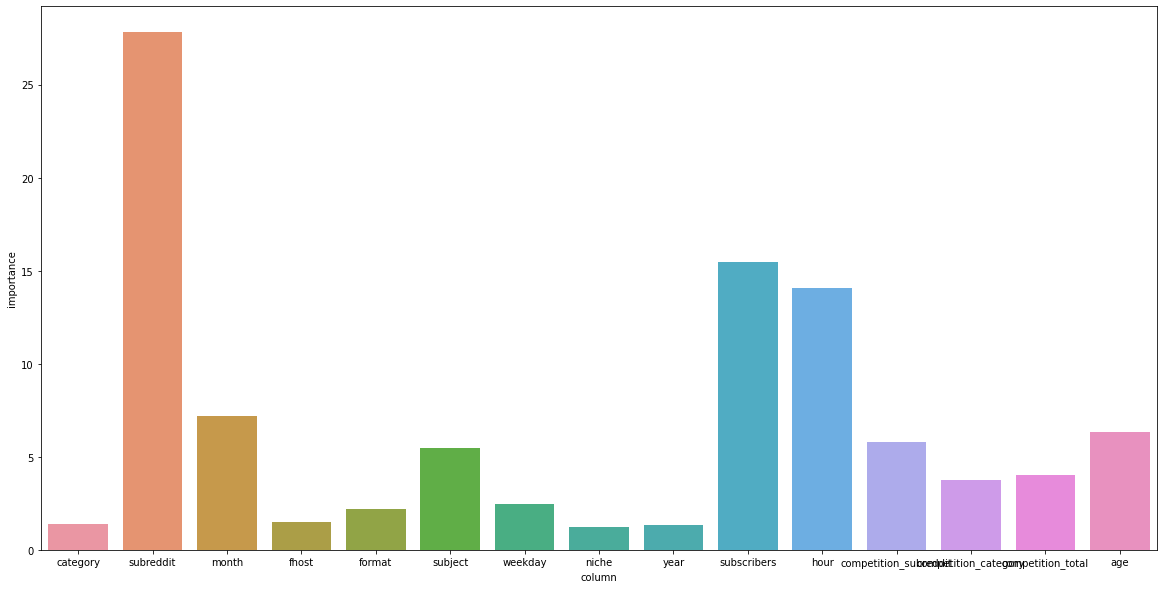

In [57]:
fig,ax = plt.subplots(figsize=(20,10))

sns.barplot(data=pd.DataFrame({"column":cat+num,"importance":model.feature_importances_}),x="column",y="importance");

In [52]:
for f,col in zip(model.feature_importances_,cat+num):
    print(f'{col}: {f}')

category: 1.3890358524800142
subreddit: 27.81443505880357
month: 7.182741457662041
fhost: 1.4779137934692155
format: 2.199124641225281
subject: 5.449796328049819
weekday: 2.479587459044383
niche: 1.2480976182120458
year: 1.3321143636060016
subscribers: 15.477032599398756
hour: 14.051143828299747
competition_subreddit: 5.770990546709901
competition_category: 3.7362391471470557
competition_total: 4.046950658603222
age: 6.344796647288927


In [76]:
model2 = CatBoostRegressor()

num = ["subscribers"]
cat = ["hour","subreddit"]
model2.fit(train[cat+num],train[target],cat_features=cat)
pred2 = model2.predict(test[cat+num])

mse(pred2,test.target,squared=False)


Learning rate set to 0.075158
0:	learn: 0.9951779	total: 26.7ms	remaining: 26.7s
1:	learn: 0.9882423	total: 50.4ms	remaining: 25.1s
2:	learn: 0.9820166	total: 82.7ms	remaining: 27.5s
3:	learn: 0.9766772	total: 117ms	remaining: 29.2s
4:	learn: 0.9719854	total: 140ms	remaining: 27.9s
5:	learn: 0.9681947	total: 173ms	remaining: 28.7s
6:	learn: 0.9647557	total: 208ms	remaining: 29.5s
7:	learn: 0.9617560	total: 274ms	remaining: 33.9s
8:	learn: 0.9588486	total: 296ms	remaining: 32.6s
9:	learn: 0.9563379	total: 362ms	remaining: 35.9s
10:	learn: 0.9541107	total: 387ms	remaining: 34.8s
11:	learn: 0.9520582	total: 426ms	remaining: 35.1s
12:	learn: 0.9505834	total: 461ms	remaining: 35s
13:	learn: 0.9489625	total: 498ms	remaining: 35.1s
14:	learn: 0.9477535	total: 527ms	remaining: 34.6s
15:	learn: 0.9464804	total: 567ms	remaining: 34.9s
16:	learn: 0.9454312	total: 619ms	remaining: 35.8s
17:	learn: 0.9446451	total: 654ms	remaining: 35.7s
18:	learn: 0.9437872	total: 679ms	remaining: 35.1s
19:	learn:

160:	learn: 0.9270126	total: 8.46s	remaining: 44.1s
161:	learn: 0.9269811	total: 8.49s	remaining: 43.9s
162:	learn: 0.9269111	total: 8.52s	remaining: 43.8s
163:	learn: 0.9268368	total: 8.55s	remaining: 43.6s
164:	learn: 0.9267833	total: 8.57s	remaining: 43.4s
165:	learn: 0.9267124	total: 8.6s	remaining: 43.2s
166:	learn: 0.9266631	total: 8.62s	remaining: 43s
167:	learn: 0.9265616	total: 8.66s	remaining: 42.9s
168:	learn: 0.9265017	total: 8.69s	remaining: 42.7s
169:	learn: 0.9264523	total: 8.73s	remaining: 42.6s
170:	learn: 0.9263404	total: 8.79s	remaining: 42.6s
171:	learn: 0.9263056	total: 8.81s	remaining: 42.4s
172:	learn: 0.9262414	total: 8.85s	remaining: 42.3s
173:	learn: 0.9261490	total: 8.88s	remaining: 42.2s
174:	learn: 0.9261164	total: 8.94s	remaining: 42.1s
175:	learn: 0.9260910	total: 8.97s	remaining: 42s
176:	learn: 0.9260360	total: 9.03s	remaining: 42s
177:	learn: 0.9259571	total: 9.05s	remaining: 41.8s
178:	learn: 0.9258671	total: 9.11s	remaining: 41.8s
179:	learn: 0.92579

321:	learn: 0.9205971	total: 13.9s	remaining: 29.2s
322:	learn: 0.9205630	total: 13.9s	remaining: 29.2s
323:	learn: 0.9205564	total: 13.9s	remaining: 29.1s
324:	learn: 0.9205157	total: 14s	remaining: 29s
325:	learn: 0.9204819	total: 14s	remaining: 29s
326:	learn: 0.9204619	total: 14.1s	remaining: 28.9s
327:	learn: 0.9204414	total: 14.1s	remaining: 28.9s
328:	learn: 0.9204090	total: 14.1s	remaining: 28.8s
329:	learn: 0.9203922	total: 14.1s	remaining: 28.7s
330:	learn: 0.9203630	total: 14.2s	remaining: 28.7s
331:	learn: 0.9203527	total: 14.2s	remaining: 28.7s
332:	learn: 0.9203494	total: 14.3s	remaining: 28.6s
333:	learn: 0.9203240	total: 14.3s	remaining: 28.5s
334:	learn: 0.9202768	total: 14.3s	remaining: 28.5s
335:	learn: 0.9202396	total: 14.4s	remaining: 28.4s
336:	learn: 0.9202074	total: 14.4s	remaining: 28.3s
337:	learn: 0.9201625	total: 14.4s	remaining: 28.3s
338:	learn: 0.9201495	total: 14.5s	remaining: 28.2s
339:	learn: 0.9201347	total: 14.5s	remaining: 28.1s
340:	learn: 0.920107

487:	learn: 0.9162886	total: 19.2s	remaining: 20.2s
488:	learn: 0.9162750	total: 19.3s	remaining: 20.1s
489:	learn: 0.9162595	total: 19.3s	remaining: 20.1s
490:	learn: 0.9162296	total: 19.3s	remaining: 20s
491:	learn: 0.9162145	total: 19.4s	remaining: 20s
492:	learn: 0.9162027	total: 19.4s	remaining: 19.9s
493:	learn: 0.9161741	total: 19.4s	remaining: 19.9s
494:	learn: 0.9161594	total: 19.4s	remaining: 19.8s
495:	learn: 0.9161533	total: 19.5s	remaining: 19.8s
496:	learn: 0.9161377	total: 19.5s	remaining: 19.7s
497:	learn: 0.9161222	total: 19.5s	remaining: 19.7s
498:	learn: 0.9160947	total: 19.6s	remaining: 19.6s
499:	learn: 0.9160771	total: 19.6s	remaining: 19.6s
500:	learn: 0.9160252	total: 19.6s	remaining: 19.5s
501:	learn: 0.9160100	total: 19.7s	remaining: 19.5s
502:	learn: 0.9159914	total: 19.7s	remaining: 19.5s
503:	learn: 0.9159066	total: 19.8s	remaining: 19.5s
504:	learn: 0.9158808	total: 19.8s	remaining: 19.4s
505:	learn: 0.9158623	total: 19.8s	remaining: 19.3s
506:	learn: 0.91

646:	learn: 0.9129988	total: 24.7s	remaining: 13.5s
647:	learn: 0.9129755	total: 24.7s	remaining: 13.4s
648:	learn: 0.9129631	total: 24.8s	remaining: 13.4s
649:	learn: 0.9129227	total: 24.8s	remaining: 13.3s
650:	learn: 0.9128961	total: 24.8s	remaining: 13.3s
651:	learn: 0.9128719	total: 24.8s	remaining: 13.3s
652:	learn: 0.9128285	total: 24.9s	remaining: 13.2s
653:	learn: 0.9128197	total: 24.9s	remaining: 13.2s
654:	learn: 0.9128088	total: 25s	remaining: 13.1s
655:	learn: 0.9128004	total: 25s	remaining: 13.1s
656:	learn: 0.9127851	total: 25s	remaining: 13.1s
657:	learn: 0.9127426	total: 25.1s	remaining: 13s
658:	learn: 0.9127179	total: 25.1s	remaining: 13s
659:	learn: 0.9126695	total: 25.1s	remaining: 13s
660:	learn: 0.9126615	total: 25.2s	remaining: 12.9s
661:	learn: 0.9126512	total: 25.2s	remaining: 12.9s
662:	learn: 0.9126409	total: 25.3s	remaining: 12.9s
663:	learn: 0.9126202	total: 25.3s	remaining: 12.8s
664:	learn: 0.9126032	total: 25.4s	remaining: 12.8s
665:	learn: 0.9125924	to

805:	learn: 0.9100083	total: 30.3s	remaining: 7.29s
806:	learn: 0.9099963	total: 30.3s	remaining: 7.26s
807:	learn: 0.9099919	total: 30.4s	remaining: 7.21s
808:	learn: 0.9099610	total: 30.4s	remaining: 7.17s
809:	learn: 0.9099310	total: 30.4s	remaining: 7.13s
810:	learn: 0.9099194	total: 30.5s	remaining: 7.1s
811:	learn: 0.9099087	total: 30.5s	remaining: 7.06s
812:	learn: 0.9098652	total: 30.6s	remaining: 7.03s
813:	learn: 0.9098505	total: 30.6s	remaining: 6.99s
814:	learn: 0.9098303	total: 30.6s	remaining: 6.95s
815:	learn: 0.9098141	total: 30.6s	remaining: 6.91s
816:	learn: 0.9097729	total: 30.7s	remaining: 6.87s
817:	learn: 0.9097558	total: 30.7s	remaining: 6.83s
818:	learn: 0.9097369	total: 30.7s	remaining: 6.79s
819:	learn: 0.9097302	total: 30.8s	remaining: 6.75s
820:	learn: 0.9097246	total: 30.8s	remaining: 6.71s
821:	learn: 0.9097130	total: 30.8s	remaining: 6.67s
822:	learn: 0.9096927	total: 30.9s	remaining: 6.64s
823:	learn: 0.9096644	total: 30.9s	remaining: 6.6s
824:	learn: 0.

966:	learn: 0.9070402	total: 35.8s	remaining: 1.22s
967:	learn: 0.9070352	total: 35.8s	remaining: 1.18s
968:	learn: 0.9070273	total: 35.8s	remaining: 1.15s
969:	learn: 0.9069886	total: 35.9s	remaining: 1.11s
970:	learn: 0.9069670	total: 35.9s	remaining: 1.07s
971:	learn: 0.9069237	total: 35.9s	remaining: 1.03s
972:	learn: 0.9068999	total: 36s	remaining: 998ms
973:	learn: 0.9068641	total: 36s	remaining: 960ms
974:	learn: 0.9068345	total: 36s	remaining: 924ms
975:	learn: 0.9068108	total: 36.1s	remaining: 887ms
976:	learn: 0.9067912	total: 36.1s	remaining: 850ms
977:	learn: 0.9067740	total: 36.1s	remaining: 813ms
978:	learn: 0.9067425	total: 36.2s	remaining: 776ms
979:	learn: 0.9067336	total: 36.2s	remaining: 739ms
980:	learn: 0.9067260	total: 36.2s	remaining: 702ms
981:	learn: 0.9066915	total: 36.3s	remaining: 665ms
982:	learn: 0.9066865	total: 36.3s	remaining: 628ms
983:	learn: 0.9066623	total: 36.4s	remaining: 591ms
984:	learn: 0.9066530	total: 36.4s	remaining: 554ms
985:	learn: 0.9066

0.9255799075203817

In [69]:
test[cat] = test[cat].astype(str)
test[num] = test[num].astype(float)

In [71]:
cat

['hour', 'subreddit']

In [75]:
test.subscribers.unique()

array([142344.,   1972.,  11384., ...,   8483.,   8470.,   8375.])

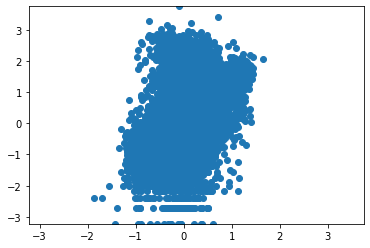

In [79]:
plt.scatter(pred,test.target)
plt.xlim(test.target.min(),test.target.max())
plt.ylim(test.target.min(),test.target.max());